In [47]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm


In [48]:
# Load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
data = pd.read_csv(url, parse_dates=['Date'], index_col='Date')

# Preprocess the dataset
temperatures = data['Temp'].values.reshape(-1, 1)

In [49]:

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_temperatures = scaler.fit_transform(temperatures)

In [50]:
n_test_years = 3
test_size = n_test_years * 365  # number of days in 3 years
train_data = normalized_temperatures[:-test_size]
test_data = normalized_temperatures[-test_size:]

In [51]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [56]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size=1, hidden_layer_size=50, output_size=1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Epoch 1/1: 100%|██████████| 158/158 [00:00<00:00, 259.70batch/s]


Epoch 0 loss: 0.0105


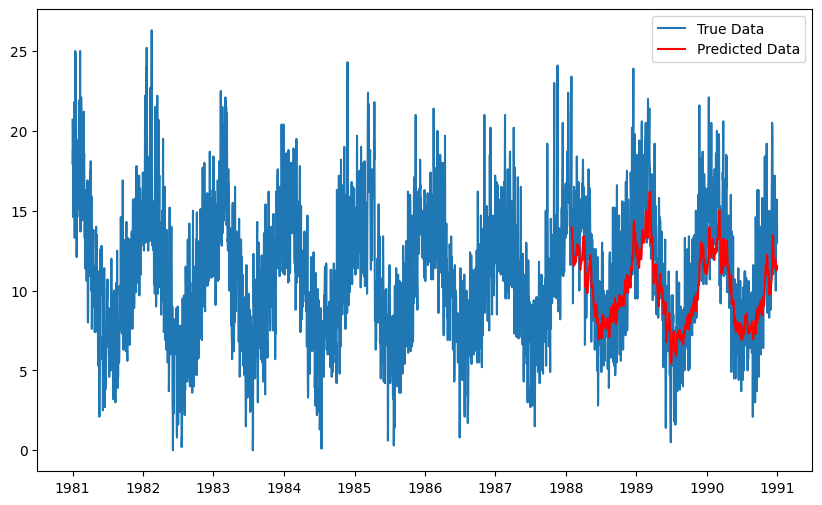

In [58]:

# Train the model
epochs = 1
for epoch in range(epochs):
    for seq, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', unit='batch'):
        optimizer.zero_grad()
        # model.hidden_cell = (torch.zeros(1, seq.size(0), model.hidden_layer_size),
        #                      torch.zeros(1, seq.size(0), model.hidden_layer_size))
        y_pred = model(seq)
        
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} loss: {single_loss.item():.4f}')

# Make predictions on the test set
model.eval()
predictions = []
with torch.no_grad():
    for i in range(len(x_test)):
        seq = x_test[i].unsqueeze(0)  # add batch dimension
        prediction = model(seq)
        predictions.append(prediction.item())

# Denormalize the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Denormalize the actual test values
actual = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# Generate dates for the test data
test_dates = data.index[-test_size + seq_length:]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(data.index, temperatures, label='True Data')
plt.plot(test_dates, predictions, label='Predicted Data', color='red')
plt.legend()
plt.show()